In [134]:
# general python ecosystem
import numpy as np
import scipy as sp
import scipy.sparse as sps
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Wedge
import ipywidgets
import random
import math


# SimPEG tools 
import discretize
from discretize.utils import mesh_builder_xyz, refine_tree_xyz
from SimPEG.potential_fields import magnetics as mag
from SimPEG.utils import mkvc, surface2ind_topo
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
    utils
)

from pymatsolver import Pardiso as Solver

Set Flags for sampling strategy and use of topography

In [135]:
inflight=1     # inflight sampling is 1; landed sampling is 0; 2 is mesh
use_topo=True 

# Forward problem

## define the geologic setup

**SimPEG conventions**
- right handed coordinate system
- z-positive up
- SI units

For this example, we assume a topography low due to the crater

In [136]:
# define MAG
target_magnetization_inclination = 45
target_magnetization_declination = 90 

target_magnetization_direction = utils.mat_utils.dip_azimuth2cartesian(
    target_magnetization_inclination, target_magnetization_declination
)

target_magnetization_amplitude = 10 # magnetization in A/m
background_magnetization = 0 # magnetization in A/m
target_magnetization = target_magnetization_amplitude * target_magnetization_direction

# define Topography if flag is set to true
[xx, yy] = np.meshgrid(np.linspace(-600, 600, 50), np.linspace(-600, 600, 50))
b = 100
A = 50

if use_topo is True:
    zz = -A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))
else: 
    zz = np.zeros_like(xx)
    
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]
print(target_magnetization)

[[ 7.07106781  0.         -7.07106781]]


## survey geometry

In [137]:
if inflight ==1:  #inflight measuremenets 
    line_length = 600
    n_data_along_line = 30
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = np.r_[-50,0, 50] 
    survey_z = np.r_[10]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])
    
    xx = np.linspace(0, 7, n_data_along_line)
    xx =np.concatenate([xx,xx,np.flip(xx)])
    
    survey_xyz[:,1] = survey_xyz[:,1]*xx
    survey_z = np.linspace(1, 30, int(n_data_along_line/2))
    zz = np.concatenate([survey_z, np.flip(survey_z), survey_z, np.flip(survey_z), survey_z, np.flip(survey_z)])
    survey_xyz[:,2] = zz

elif inflight == 2: # grid
    line_length = 600
    n_data_along_line = 15
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = survey_x
    survey_z = np.r_[10]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])

else:
    line_length = 600
    n_data_along_line = 6
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = np.r_[0] 
    survey_z = np.r_[1]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])


## create a mesh

Here, we use a tensor mesh 

In [138]:
from discretize import TensorMesh

nc = 40  # number of core mesh cells in x, y and z
dh = 20   # base cell width in x, y and z
npad = 10  # number of padding cells
exp = 1  # expansion rate of padding cells

h = [(dh, npad, -exp), (dh, nc), (dh, npad, exp)]
mesh = TensorMesh([h, h, h], x0="CCC")

# Define an active cells from topo
actv = utils.surface2ind_topo(mesh, topo)
nC = int(actv.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell

mesh

TensorMesh: 216,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     60       -600.00        600.00     20.00     20.00    1.00
   y     60       -600.00        600.00     20.00     20.00    1.00
   z     60       -600.00        600.00     20.00     20.00    1.00

#### put the model on the mesh and create an acive cell map to ignore air cells.  

In [139]:
ind = utils.model_builder.getIndicesSphere([0,0,-40], 120, mesh.gridCC)

magnetization = np.ones((mesh.nC, 3))*background_magnetization
magnetization[ind, :] = target_magnetization
model = magnetization[actv, :]

active_cell_map = maps.InjectActiveCells(mesh=mesh, indActive=actv, valInactive=np.nan)

### define some useful plotting functions

In [140]:
def full_mesh_magnetization(model,nC,active_cell_map):
    return np.vstack([active_cell_map * model.reshape(nC, 3, order="F")[:, i] for i in range(3)]).T

In [141]:
def plot_vector_model(
    mesh, nC, active_cell_map, maxval, model, ax=None, quiver_opts=None, normal="Y", xlim=None, ylim=None, ind=None, plot_data=True, plot_grid=False, outline=True
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    magnetization = full_mesh_magnetization(model,nC,active_cell_map)
    qo = {
        "units":"xy", "scale":np.max(np.abs(model))/20,
        "headwidth":7, "headlength":5, "headaxislength":1
    }
    
    # overwrite default vals if user provides them 
    if quiver_opts is not None:
        for key, val in quiver_opts.items(): 
            qo[key] = val 

    cb = plt.colorbar(
        mesh.plot_slice(
            magnetization, "CCv", clim=[0,maxval],normal=normal, ax=ax, view="vec", 
            grid=plot_grid, ind=ind, quiver_opts=qo,label=False, stream_opts={"color":"k","arrowsize":3}
        )[0], ax=ax
    )
    
    cb.set_label("amplitude magnetization (A/m)", fontsize=14)

    if outline is True:
        theta1, theta2 = 0, 0 + 180
        radius = 120
        center = (0, -40)
        w2 = Wedge(center, radius, theta2, theta1, fill=False, edgecolor='black',linestyle="dashed",linewidth=2)
        circle = plt.Circle((0, 0), 120, color='black', linestyle="dashed", linewidth=2,fill=False) 

    if normal.upper() == "X": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 1], survey_xyz[:, 2], "C1o", ms=4,label=False)
        if outline is True:
            ax.add_artist(w2)
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
        ax.set_title(f"x at {mesh.vectorCCy[ind]} m", fontsize=14)
    elif normal.upper() == "Y": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=4,label=False)
        if outline is True:
            ax.add_artist(w2)
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
        ax.set_title(f"y at {mesh.vectorCCy[ind]} m", fontsize=14)
        ax.set_title("y at 0 m", fontsize=14)
    elif normal.upper() == "Z": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 1], "C1o", ms=4,label=False)
        if outline is True:
            ax.add_artist(circle)
        ax.set_xlim([survey_x.min()*1.25, survey_x.max()*1.25] if xlim is None else xlim)
        ax.set_ylim([survey_x.min()*1.25, survey_x.max()*1.25] if ylim is None else ylim)
        ax.set_title(f"z at {mesh.vectorCCy[ind]} m", fontsize=14)
    ax.set_aspect(1)
    
def plot_amplitude(
        mesh, nC, active_cell_map, maxval, model, ax=None, quiver_opts=None, normal="Y", xlim=None, ylim=None, ind=None, plot_data=True, plot_grid=False, outline=True
    ):
        if ax is None: 
            fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        qo = {
            "units":"xy", "scale":np.max(np.abs(model))/20,
            "headwidth":7, "headlength":10, "headaxislength":10
        }
        
        # overwrite default vals if user provides them 
        if quiver_opts is not None:
            for key, val in quiver_opts.items(): 
                qo[key] = val 
                
        magnetization = full_mesh_magnetization(model,nC,active_cell_map)
        Mtotal = np.sqrt(magnetization[:,0]**2 + magnetization[:,1]**2 + magnetization[:,2]**2)
                
        cb = plt.colorbar(
            mesh.plot_slice(
                Mtotal, "CC", clim=[0,maxval],normal=normal, ax=ax, view="abs", 
                grid=plot_grid, ind=ind, quiver_opts=qo
                )[0], ax=ax
            )
        
        cb.set_label("amplitude magnetization [A/m]", fontsize=14)
        
        if outline is True:
            theta1, theta2 = 0, 0 + 180
            radius = 120
            center = (0, -40)
            w2 = Wedge(center, radius, theta2, theta1, fill=False, edgecolor='black',linestyle="dashed",linewidth=2)
            circle = plt.Circle((0, 0), 120, color='black', linestyle="dashed", linewidth=2,fill=False) 

        if normal.upper() == "X": 
            if plot_data is True: 
                ax.plot(survey_xyz[:, 1], survey_xyz[:, 2], "C1o", ms=4,label=False)
            if outline is True:
                ax.add_artist(w2)
            ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
            ax.set_title(f"x at {mesh.vectorCCy[ind]} m", fontsize=14)
        elif normal.upper() == "Y": 
            if plot_data is True: 
                ax.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=4,label=False)
            if outline is True:
                ax.add_artist(w2)
            ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
            ax.set_title(f"y at {mesh.vectorCCy[ind]} m", fontsize=14)
            ax.set_title("y at 0 m", fontsize=14)
        elif normal.upper() == "Z": 
            if plot_data is True: 
                ax.plot(survey_xyz[:, 0], survey_xyz[:, 1], "C1o", ms=4,label=False)
            if outline is True:
                ax.add_artist(circle)
            ax.set_xlim([survey_x.min()*1.25, survey_x.max()*1.25] if xlim is None else xlim)
            ax.set_ylim([survey_x.min()*1.25, survey_x.max()*1.25] if ylim is None else ylim)
            ax.set_title(f"z at {mesh.vectorCCy[ind]} m", fontsize=14)
        ax.set_aspect(1)

#### Now plot the model 

vectors indicate magnetization direction in `plot_vector_model` while 'plot_amplitude' will provide amplitude of magnetization. 

Note that if you would like to change the index of the slices (cross section or depth slice, you can provide an `ind` value to the `plot_vector_model` function)

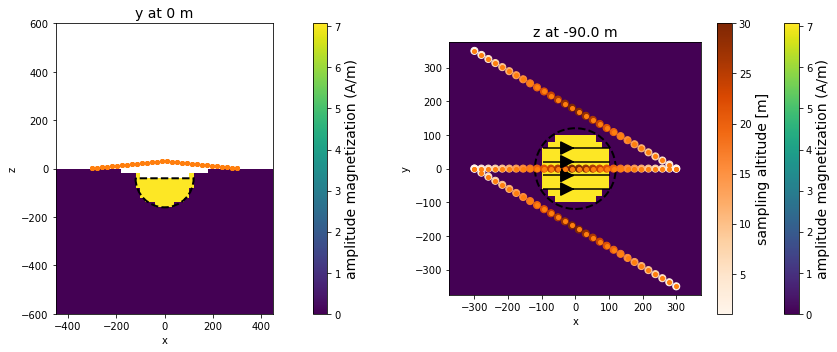

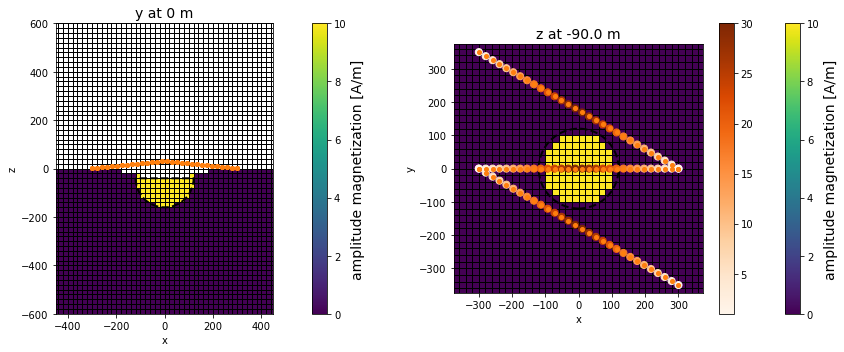

In [142]:
maxval = np.max(np.abs(model))
zind = 25

fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
plot_vector_model(mesh, nC, active_cell_map,maxval,model, ax=ax[0],ind=(int(mesh.nCy/2)))
plot_vector_model(mesh, nC, active_cell_map,maxval,model, ax=ax[1], normal="Z", ind=zind,plot_data=True)  # APPEND WITHOUT GRID,plot_grid=False
plt.tight_layout()
if inflight == 1:
    plt.scatter(survey_xyz[:,0], survey_xyz[:,1],c=survey_xyz[:,2], cmap="Oranges", s=50)
    cb2 = plt.colorbar()
    cb2.set_label("sampling altitude [m]", fontsize=14)

maxval = target_magnetization_amplitude
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
plot_amplitude(mesh, nC, active_cell_map,maxval,model, ax=ax[0],ind=(int(mesh.nCy/2)), plot_grid=True)


plot_amplitude(mesh, nC, active_cell_map,maxval,model, ax=ax[1], normal="Z", ind=zind,plot_grid=True,plot_data=True)  # APPEND WITHOUT GRID,plot_grid=False
plt.tight_layout()

if inflight == 1:
    plt.scatter(survey_xyz[:,0], survey_xyz[:,1],c=survey_xyz[:,2], cmap="Oranges", s=50)
    plt.colorbar()


## setup and run the forward simulation

### survey

We create a survey object that keeps track of what data we are measuring and where. We create a `source_field` because the code was designed thinking about "effective susceptibility" being the model parameter. The orientation makes no impact, it is only a scaling. So since the problem is linear, if we use an amplitude of 1 for the source field, then we can consider the model to be magnetization, and there is no induced component. 

In [143]:
components = ["x", "y", "z"]
rx = mag.receivers.Point(locations=survey_xyz, components=[f"b{comp}" for comp in components])

source_field = mag.sources.SourceField(
    receiver_list=[rx], parameters=np.r_[1., 0, 0]
)
survey = mag.survey.Survey(source_field)

### simulation 

The simulation object is what we use to create our synthetic data

In [144]:
simulation = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=maps.IdentityMap(nP=np.prod(model.shape)), 
    actInd=actv, model_type="vector"
)

### run the simulation

The `synthetic_data` is an object that keeps track of the simulated data. It keeps the clean data (`synthetic_data.dclean`), the data that will be used in the inversion (`synthetic_data.dobs`), whether those data are contaminated with noise (`add_noise`), and the standard deviation of the noise. 

The standard deviation of the noise assigned here will later be used in the inversion. Note that `noise_floor` should be greater than 0. 

The data misfit that we will later construct for the inversion is as follows:
$$
\phi_d = \| \mathbf{W}_d(\mathbf{d}^{\rm pred} - \mathbf{d}^{\rm obs} )\|^2
$$

with 
- $\mathbf{W}_d = {\rm diag}(1/\epsilon_j)$
- $\epsilon_j = $ `relative_error * abs(dobs) + noise_floor`


In [145]:
synthetic_data = simulation.make_synthetic_data(
    utils.mkvc(model), 
    noise_floor=0.1, # standard deviation of the noise in nT 
    relative_error=0,  # if you want to include a percent noise 
    add_noise=True  # do we add noise to the data we will use in the inversion?
) 

In [146]:
survey_z_s = [1]
def plot_data_profile(data, plot_opts=None, ax=None, xlim=None, ylim=None, label=True):
    data = data.reshape((survey_xyz.shape[0], len(components)))
    
    if ax is None: 
        fig, ax = plt.subplots(1, len(components), figsize=(5*len(components), 4))
        ax = np.atleast_2d(ax)
    
    po = {"ms": 3}
    if plot_opts is not None: 
        for key, val in plot_opts.items():
            po[key] = val 
    
    for k, zloc in enumerate(survey_z_s): 
        for i, component in enumerate(components):
            d = data[:, i].reshape(len(survey_x), len(survey_y), len(survey_z_s), order="F")
            for j, y in enumerate(survey_y):
                if not isinstance(label, bool):
                    l=f"{y:1.0f} m {label}"
                else:
                    l=f"{y:1.0f} m" if label is True else None
                ax[k, i].plot(survey_x, d[:, j, k], f"C{j}", label=l, **po)

            ax[k, i].set_title(f"B{component} z={zloc}m")
            ax[k, i].grid("both", alpha=0.6)
            ax[k, i].set_ylim(1.25 * np.r_[data.min(), data.max()] if ylim is None else ylim)
            ax[k, i].set_xlim(xlim)
            ax[k, i].set_xlabel("x (m)")
    
    ax[0, 0].set_ylabel("magnetic field (nT)")
    if label is not False: 
        ax[0, 0].legend()
    plt.tight_layout()
    return ax
    

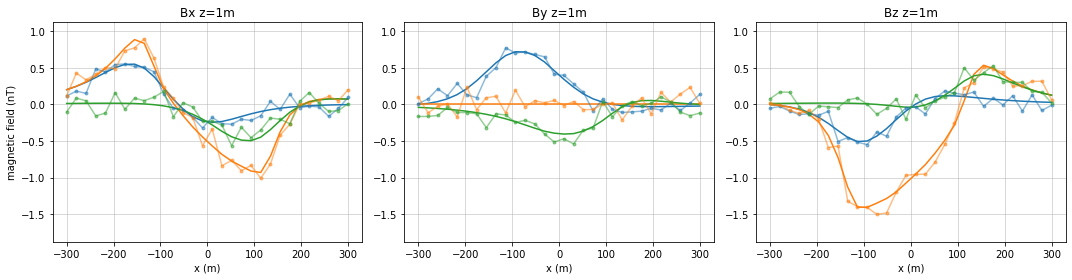

In [147]:
ax = plot_data_profile(synthetic_data.dclean,label=False)
ax = plot_data_profile(synthetic_data.dobs, ax=ax, plot_opts={"marker":"o", "alpha":0.5},label=False)

In [148]:
def plot_2d_data(data, ax=None, title=None, xlabel=True):
    if ax is None: 
        fig, ax = plt.subplots(len(survey_z_s), len(components), figsize=(2.2*len(components), 2.1), sharex=True, sharey=True)
        ax = np.atleast_2d(ax)
        
    data = data.reshape((survey_xyz.shape[0], len(components)))
    #append amplitude as last column to data
    data = np.c_[data, np.sqrt(np.sum(data**2, axis=1))]
    plotting_xyz = discretize.utils.ndgrid(survey_x, survey_y)
    
    for k, zloc in enumerate(survey_z_s):
        
        norm = Normalize(vmin=np.min(data), vmax=np.max(data))
        
        for i, component in enumerate(components): 
            d = data[:, i].reshape(len(survey_x), len(survey_y), len(survey_z_s), order="F")
            out = utils.plot2Ddata(plotting_xyz, utils.mkvc(d[:, :, k]), ax=ax[k, i], contourOpts={"norm":norm, "levels":10})
            
            if i == len(components) - 1:
                plt.colorbar(out[0], ax=ax[k, i], label="B (nT)")
        
            ax[k, i].set_title(f"B{component} {title}, z={zloc} m")
            ax[k, i].plot(survey_xyz[:, 0], survey_xyz[:, 1], "k.", ms = 2)

            if xlabel is True:
                ax[-1, i].set_xlabel("x (m)")

        ax[k, 0].set_ylabel("y (m)")
    plt.tight_layout()
    
    return ax

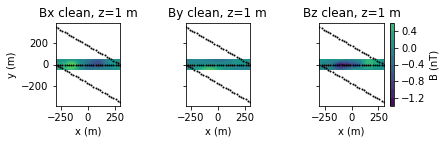

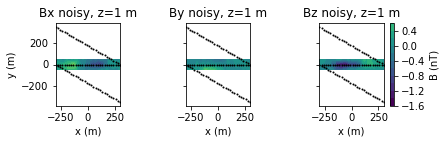

In [149]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dclean, title="clean")
if len(survey_y) > 1:
    plot_2d_data(synthetic_data.dobs, title="noisy")

## Inversion 

### in cartesian coordinates 
This is a linear inverse problem if we use L2 regularization. 
We start by setting up the regularisation

In [150]:
wires = maps.Wires(("x", nC), ("y", nC), ("z", nC))

reg_x = regularization.Sparse(mesh, indActive=actv, mapping=wires.x)
reg_y = regularization.Sparse(mesh, indActive=actv, mapping=wires.y)
reg_z = regularization.Sparse(mesh, indActive=actv, mapping=wires.z)

norms = [[2, 2, 2, 2]]
reg_x.norms = norms
reg_y.norms = norms
reg_z.norms = norms

reg = reg_x + reg_y + reg_z

Data misfit

In [151]:
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation)

Optimization

In [152]:
opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=20, tolCG=1e-4
)

Set up inversion problem

In [153]:

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [154]:
inversion.BaseInversion.directiveList

Add some directives, including 
(1) the tradeoff parameter beta
(2) add sensitivity weights 
(3) Pre-conditioner
(4) set target misfit
and put everything together. 

In [155]:

betaest = directives.BetaEstimate_ByEig(beta0_ratio=6)  
sensitivity_weights = directives.UpdateSensitivityWeights()  
IRLS = directives.Update_IRLS()  
update_Jacobi = directives.UpdatePreconditioner()  
target = directives.TargetMisfit(chifact=1)  
save_iteration = directives.SaveModelEveryIteration()

inv = inversion.BaseInversion(
    inv_prob, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest, target#,save_iteration
    ]
)

### run the inversion

In [156]:
m0 = np.zeros(nC * 3)
mrec_cartesian = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/annamittelholz/opt/anaconda3/envs/mars-mag/lib/python3.7/site-packages/pymatsolver/direct.py:26: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  factor=False


SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2023-04-03-14-53.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.20e-02  1.91e+03  0.00e+00  1.91e+03    6.39e+01      0              
   1  6.01e-03  5.19e+02  3.36e+04  7.21e+02    1.66e+01      0              
   2  3.00e-03  3.08e+02  5.83e+04  4.83e+02    1.31e+01      0   Skip BFGS  
   3  1.50e-03  1.84e+02  8.70e+04  3.15e+02    1.00e+01      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 1.9473293555684217 eps_q: 1.9473293555684217
eps_p: 1.9812694547707381 eps_q: 1.9812694547707381
eps_p: 2.3504341940377134 eps_q: 2.3504341940377134
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+0

#### Plot those models

In [157]:
def generate_semicircle(center_x, center_y, radius, stepsize=0.1):
    """
    generates coordinates for a semicircle, centered at center_x, center_y
    """        

    x = np.arange(center_x, center_x+radius+stepsize, stepsize)
    y = np.sqrt(radius**2 - x**2)

    # since each x value has two corresponding y-values, duplicate x-axis.
    # [::-1] is required to have the correct order of elements for plt.plot. 
    x = np.concatenate([x,x[::-1]])

    # concatenate y and flipped y. 
    y = np.concatenate([y,-y[::-1]])

    return x, y + center_y

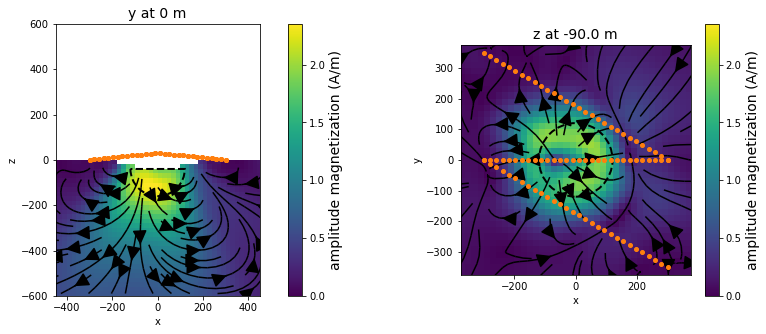

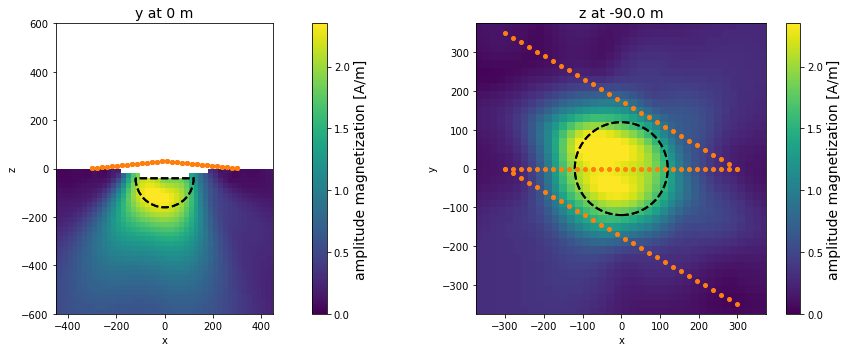

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
maxval = np.max(np.abs(mrec_cartesian))
quiver_opts = {
    "scale":np.max(np.abs(mrec_cartesian))/20,
}

plot_vector_model(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[0])
plot_vector_model(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[1], normal="Z", ind=25)


fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
quiver_opts='None'
plot_amplitude(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[0], outline=True)
# PLot half circle of radius 120 around 0,-40 for z<0 
theta1, theta2 = 0, 0 + 180
radius = 120
center = (0, -40)
from matplotlib.patches import Wedge
w2 = Wedge(center, radius, theta2, theta1, fill=False, edgecolor='black',linestyle="dashed",linewidth=2)
ax[0].add_artist(w2)

plot_amplitude(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[1], normal="Z", ind=25, outline=True)
circle = plt.Circle((0, 0), 120, color='black', linestyle="dashed", linewidth=2,fill=False)
ax[1].add_artist(circle)




plt.tight_layout()

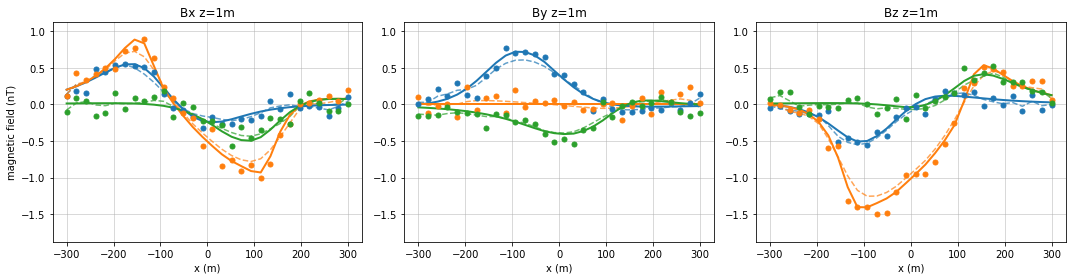

In [159]:
ax = plot_data_profile(inv_prob.dpred, plot_opts={"linestyle":"--", "alpha":0.7},label=False)
ax = plot_data_profile(synthetic_data.dclean, ax=ax,plot_opts={"lw":2},label=False)
ax = plot_data_profile(synthetic_data.dobs, ax=ax, plot_opts={"marker":"o", "lw":0,"ms":5}, label=False)

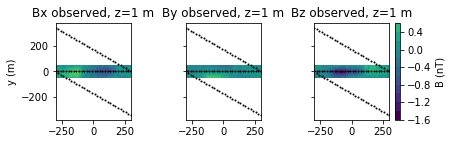

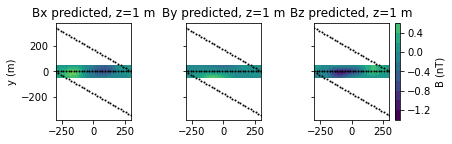

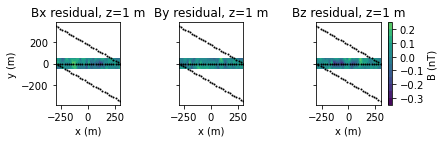

In [160]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dobs, title="observed", xlabel=False)
    plot_2d_data(inv_prob.dpred, title="predicted", xlabel=False)
    plot_2d_data(synthetic_data.dobs - inv_prob.dpred, title="residual")

    plt.tight_layout()

### Sparse inversion in spherical coordinates

This allows us to impose regularization on amplitude and direction independently. 

In [161]:
## inversion in spherical coordinates
spherical_map = maps.SphericalSystem(nP=nC*3)

wires = maps.Wires(("amplitude", nC), ("theta", nC), ("phi", nC))

In [162]:
# create the regularization
reg_amplitude = regularization.Sparse(mesh, indActive=actv, mapping=wires.amplitude,gradientType="total")
reg_theta = regularization.Sparse(mesh, indActive=actv, mapping=wires.theta,gradientType="total")
reg_phi = regularization.Sparse(mesh, indActive=actv, mapping=wires.phi,gradientType="total")

norms = [[1, 0, 0, 0]]

reg_amplitude.norms = norms
reg_theta.norms = norms
reg_phi.norms = norms

# set reference model to zero
reg_amplitude.mref = np.zeros(nC*3)
reg_theta.mref = np.zeros(nC*3)
reg_phi.mref = np.zeros(nC*3)

reg_amplitude.objfcts = reg_x.objfcts[:-1]
reg_theta.objfcts = reg_y.objfcts[:-1]
reg_phi.objfcts = reg_z.objfcts[:-1]

# don't impose reference angles
reg_theta.alpha_s = 0. 
reg_phi.alpha_s = 0.
reg_amplitude.alpha_s = 0.2#0.3


reg_spherical = reg_amplitude + reg_theta + reg_phi

In [163]:
simulation_spherical = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=spherical_map, 
    actInd=actv, model_type="vector"
)

dmis_spherical = data_misfit.L2DataMisfit(simulation=simulation_spherical, data=synthetic_data)

In [164]:
# optimization
opt_spherical = optimization.InexactGaussNewton(
    maxIter=20, maxIterCG=20, tolCG=1e-4
)

In [165]:
inv_prob_spherical = inverse_problem.BaseInvProblem(
    dmis_spherical, reg_spherical, opt_spherical, beta=inv_prob.beta
)

In [166]:
# directives 
spherical_projection = directives.ProjectSphericalBounds()  
sensitivity_weights = directives.UpdateSensitivityWeights()
IRLS = directives.Update_IRLS(
    sphericalDomain=True, beta_tol=0.1
)
update_Jacobi = directives.UpdatePreconditioner()
save_iteration = directives.SaveModelEveryIteration()

In [167]:
inv_spherical = inversion.BaseInversion(
    inv_prob_spherical, directiveList=[
        spherical_projection, sensitivity_weights, IRLS, update_Jacobi#,save_iteration
    ]
)

In [168]:
mstart = utils.cartesian2spherical(mrec_cartesian.reshape((nC, 3), order="F"))
mrec_spherical = inv_spherical.run(mstart)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/annamittelholz/opt/anaconda3/envs/mars-mag/lib/python3.7/site-packages/pymatsolver/direct.py:26: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  factor=False


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.51e-04  1.21e+02  2.76e+05  3.29e+02    1.76e+01      0              
   1  3.76e-04  1.49e+02  1.57e+05  2.08e+02    1.89e+01      1              
   2  1.88e-04  1.38e+02  1.12e+05  1.59e+02    3.49e+01      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 4.131174261592632 eps_q: 4.131174261592632
eps_p: 1.570731632628305 eps_q: 1.570731632628305
eps_p: 3.141432733338993 eps_q: 3.141432733338993
   3  9.39e-05  9.34e+01  4.42e+05  1.35e+02    1.41e+01      0              
   4  1.77e-04  7.67e+01  7.40e+05  2.07e+02    2.50e+01      0              
   5  3.04e-04  9.33e+01  2.61e+05  1.73e+02    1.22e+01      0              
   6  5.41e-04  8.66e+01  3.51e+05

##### Plotting Time
Now plot the sparse model 

15.231522229439163


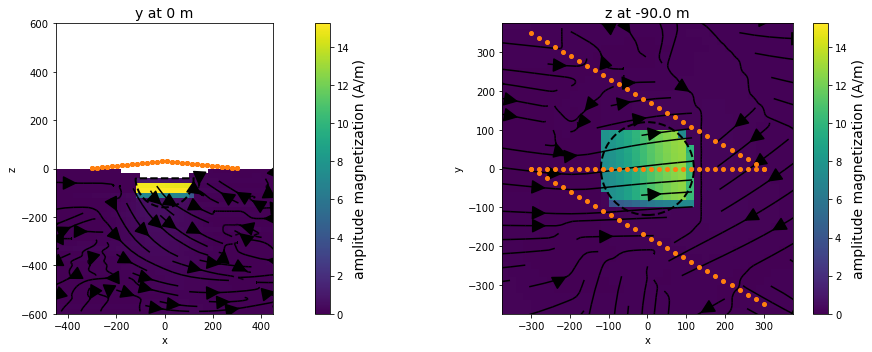

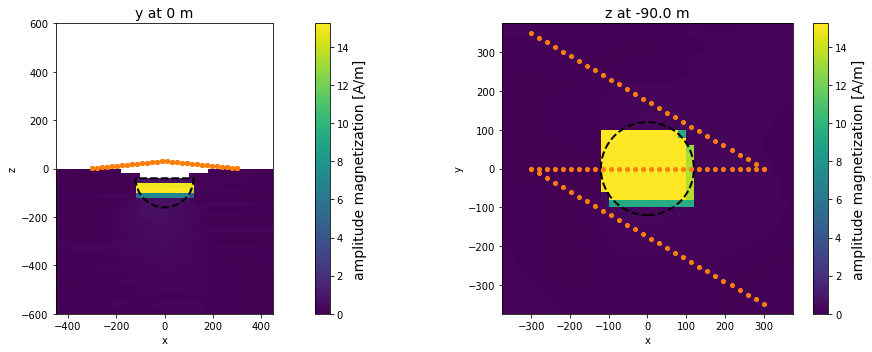

In [169]:

zind = 25
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

quiver_opts = {
    "scale":np.max(np.abs(mrec_spherical))/20,
}

m = spherical_map * mrec_spherical
maxval = np.max(np.abs(m))
print(np.max(np.abs(m)))

plot_vector_model(mesh, nC, active_cell_map,maxval,m, ax=ax[0])
plot_vector_model(mesh, nC, active_cell_map,maxval,m, ax=ax[1], normal="Z", ind=zind)
plt.tight_layout()

#maxval=target_magnetization_amplitude
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})
quiver_opts = 'None'
plot_amplitude(mesh, nC, active_cell_map,maxval,m, ax=ax[0])
plot_amplitude(mesh, nC, active_cell_map,maxval,m, ax=ax[1], normal="Z", ind=zind)
plt.tight_layout()



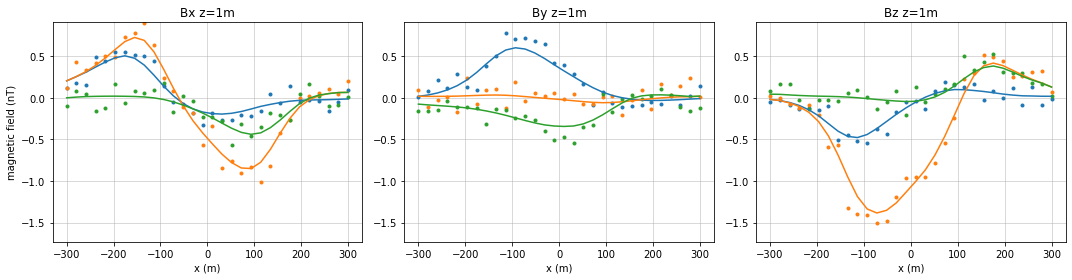

In [170]:
ax = plot_data_profile(synthetic_data.dobs, plot_opts={"marker":"o", "lw":0}, label=False)
ax = plot_data_profile(inv_prob_spherical.dpred, ax=ax, label=False)

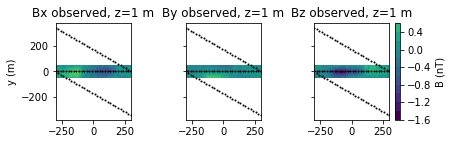

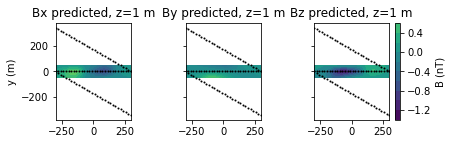

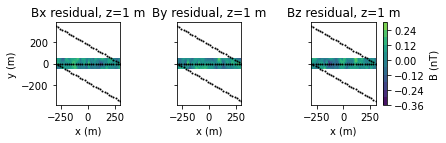

In [171]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dobs, title="observed", xlabel=False)
    plot_2d_data(inv_prob_spherical.dpred, title="predicted", xlabel=False)
    plot_2d_data(synthetic_data.dobs - inv_prob_spherical.dpred, title="residual")

    plt.tight_layout()

### Parameterized Inversion
Now we try the parametrized approach knowing that we deal with a crater

Start by defining our geometry, in this case a (half) magnetized sphere

In [172]:
class MagnetizedSphere(maps.BaseParametric):
    """
    Mapping for a sphere of radius R in a wholespace 
    
    m = [x, y, z, r, mx, my, mz]
    
    is the position, radius and magnetization in each direction 
    """
        
    @property
    def nP(self):
        return 7

    @property
    def shape(self):
        if self.indActive is not None: 
            return (self.indActive.sum()*3, self.nP)
        return (self.mesh.nC * 3, self.nP)
    
    def _root_distance(self, m):
        x, y, z = m[0], m[1], m[2]
        return np.sqrt((self.x - x) ** 2 + (self.y - y) ** 2 + (self.z - z)**2)
    
    def _sphere(self, m):
        r = m[3]
        sphere = r - self._root_distance(m)
        return sphere

    def _sphere_deriv_x(self, m): 
        x, y, z = m[0], m[1], m[2]
        return -(self.x - x) / self._root_distance(m)
    
    def _sphere_deriv_y(self, m): 
        x, y, z = m[0], m[1], m[2]
        return -(self.y - y) / self._root_distance(m)
    
    def _sphere_deriv_z(self, m): 
        x, y, z = m[0], m[1], m[2]
        return -(self.z - z) / self._root_distance(m)
    
    def _sphere_deriv_r(self, m): 
        return -np.ones(self.indActive.sum())

    def _transform(self, m):
        mx, my, mz = m[4], m[5], m[6]
        sphere = self._atanfct(self._sphere(m), self.slope)
        return np.hstack([mx * sphere, my * sphere, mz * sphere])

    def deriv(self, m, v=None):
        mx, my, mz = m[4], m[5], m[6]
        zeros = np.zeros(self.indActive.sum())
        
        atanfctderiv = self._atanfctDeriv(self._sphere(m), self.slope)
        
        sphere_deriv_x = atanfctderiv * self._sphere_deriv_x(m)
        deriv_x = np.hstack([mx * sphere_deriv_x, my * sphere_deriv_x, mz * sphere_deriv_x]) 
        
        sphere_deriv_y = atanfctderiv * self._sphere_deriv_y(m)
        deriv_y = np.hstack([mx * sphere_deriv_y, my * sphere_deriv_y, mz * sphere_deriv_y])
        
        sphere_deriv_z = atanfctderiv * self._sphere_deriv_z(m)
        deriv_z = np.hstack([mx * sphere_deriv_z, my * sphere_deriv_z, mz * sphere_deriv_z])
        
        dr = self._atanfctDeriv(self._sphere(m), self.slope) * self._sphere_deriv_r(m)
        deriv_r = np.hstack([mx*dr, my*dr, mz*dr])
        
        sphere = self._atanfct(self._sphere(m), self.slope)
        deriv_mx = np.hstack([sphere, zeros, zeros])
        deriv_my = np.hstack([zeros, sphere, zeros])
        deriv_mz = np.hstack([zeros, zeros, sphere])
        
        deriv = sps.csr_matrix(np.c_[
            deriv_x, deriv_y, deriv_z, deriv_r, deriv_mx, deriv_my, deriv_mz
        ])
        
        if v is not None:
            return deriv * v
        return deriv

Lets try it out and plot it after defining it on our mesh

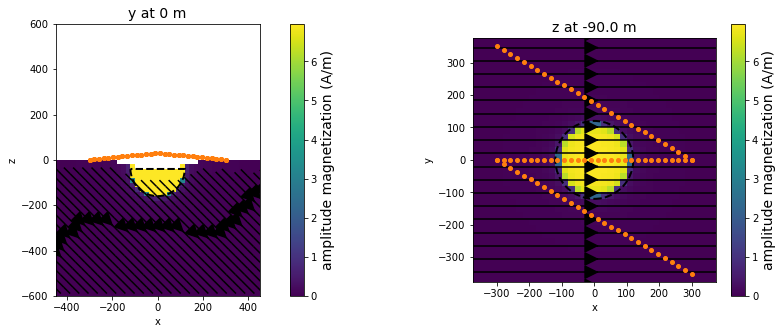

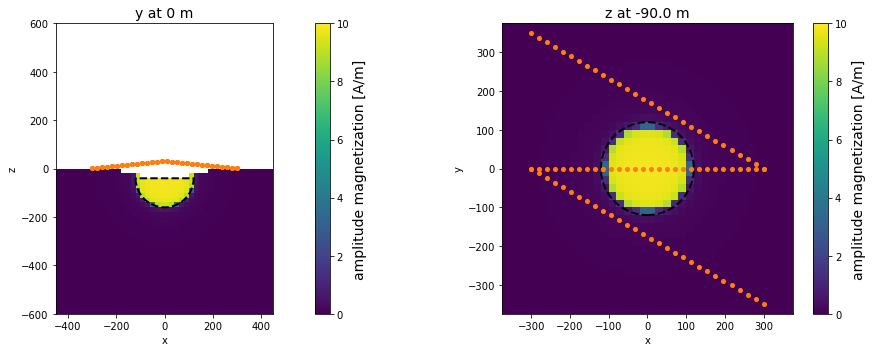

In [173]:
# %% sphere 
sphere_map = MagnetizedSphere(mesh, indActive=active_cell_map.indActive, slope=5e-1)
mtest = np.r_[0, 0, -40, 120, 7, 0, -7]  #m = [x, y, z, r, mx, my, mz]
np.abs(sphere_map * mtest)[:actv.sum()].min()


# PLOT
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})
maxval=np.abs(sphere_map * mtest).max()
plot_vector_model(mesh, nC, active_cell_map, maxval, sphere_map * mtest, ax=ax[0])
plot_vector_model(mesh, nC, active_cell_map, maxval, sphere_map * mtest, ax=ax[1], normal="Z", ind=zind)  # APPEND WITHOUT GRID,plot_grid=False

fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})
maxval=target_magnetization_amplitude
quiver_opts = 'None'
plot_amplitude(mesh, nC, active_cell_map, maxval,sphere_map * mtest, ax=ax[0])
plot_amplitude(mesh, nC, active_cell_map, maxval,sphere_map * mtest, ax=ax[1], normal="Z", ind=zind)


plt.tight_layout()

Now set up the inversion with the 'sphere_map'. Note: We need to create the regularisation and set to 0 because the code requires a regularisation argument

In [174]:
simulation_parametric = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=sphere_map, 
    actInd=actv, model_type="vector", solver=Solver
)


# %% create the regularization
reg = regularization.SimpleSmall(mesh=discretize.TensorMesh([sphere_map.nP]))

# simulation2.G dimensions mismatch 
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation_parametric)

# optimization
opt = optimization.ProjectedGNCG(
    maxIter=20, maxIterLS=20, maxIterCG=20, tolCG=1e-4,
    lower=np.r_[-np.inf, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf]
)

# inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0.01)  

# directives 
target = directives.TargetMisfit(chifact=0)  # target misfit LH 0

inv = inversion.BaseInversion(
    inv_prob, directiveList=[target]
)

Run the inversion

In [175]:
m0_parametric = np.r_[0, 0, 0, 100, 1, 1, 1]  # note: can't start at all zeros, it will fail to find a search direction
mrec_parametric = inv.run(m0_parametric)

print(mrec_parametric)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  1.97e+03  0.00e+00  1.97e+03    1.35e+02      0              
   1  1.00e-02  1.36e+03  1.89e+03  1.38e+03    1.17e+02      0              
   2  1.00e-02  5.79e+02  1.40e+03  5.93e+02    7.70e+01      1              
   3  1.00e-02  4.72e+02  6.85e+02  4.79e+02    1.67e+02      0              
   4  1.00e-02  1.28e+02  5.31e+02  1.34e+02    1.26e+01      0              
   5  1.00e-02  1.23e+02  4.09e+02  1.27e+02    2.39e+00      0   Skip BFGS  
   6  1.00e-02  1.23e+02  4.01e+02  1.27e+02    8.37e-02  

Time to plot the new model

8.780188231888841


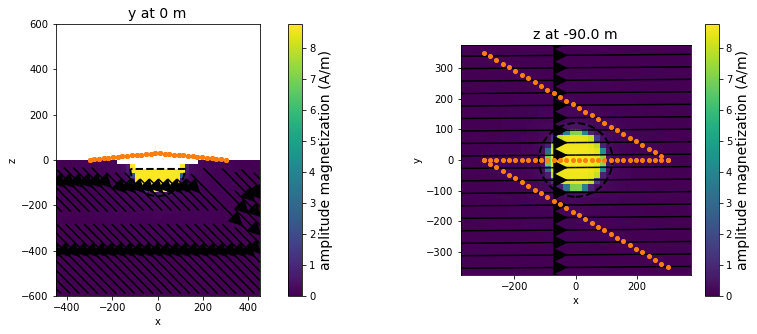

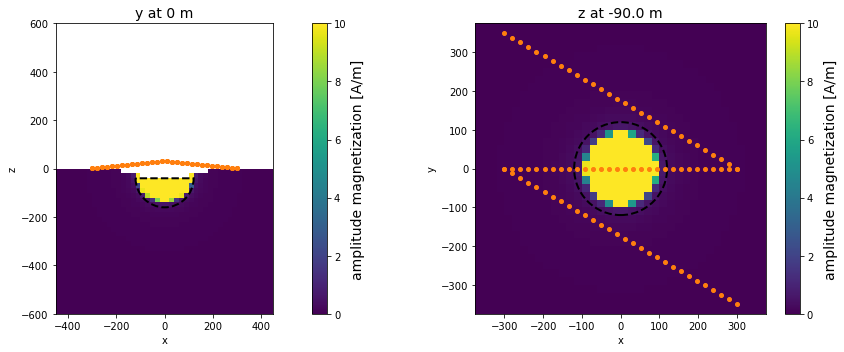

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

maxval=np.max(np.abs(sphere_map * mrec_parametric))
print(maxval)
plot_vector_model(mesh, nC, active_cell_map, maxval, sphere_map * mrec_parametric, ax=ax[0])
plot_vector_model(mesh, nC, active_cell_map, maxval, sphere_map * mrec_parametric, ax=ax[1], normal="Z", ind=zind)  # APPEND WITHOUT GRID,plot_grid=False

fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
maxval = target_magnetization_amplitude
quiver_opts = 'None'
plot_amplitude(mesh, nC, active_cell_map, maxval,sphere_map * mrec_parametric, ax=ax[0])
plot_amplitude(mesh, nC, active_cell_map, maxval,sphere_map * mrec_parametric, ax=ax[1], normal="Z", ind=zind)

plt.tight_layout()